# Data Prep

### Data Fetch From Trino


In [1]:
"""
This script establishes a connection to a Presto database via the Trino Python client, 
executes a SQL query to fetch data, and then structures the fetched data into a pandas DataFrame.
The DataFrame is Clusters with appropriate column names, making the data ready for analysis.
"""

import trino
import pandas as pd
import getpass
import datetime

# Get password
password = getpass.getpass("Enter your password: ")

# Connect to Trino
conn = trino.dbapi.connect(
    host="presto-gateway.corp.mongodb.com",
    port=443,
    user="jiawei.zhou@mongodb.com",
    catalog="awsdatacatalog",
    http_scheme="https",
    auth=trino.auth.BasicAuthentication("jiawei.zhou@mongodb.com", password),
)

# Execute query
cur = conn.cursor()

/Users/jiawei.zhou/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
cur.execute(
    f"""
with cluster_info as (
select
	*
from
	awsdatacatalog.product_analytics.pnl_org_cluster_meta_data_full_history
where
	tier <> 'FREE'
	and is_deleted = false
	and cluster_mrr_total > 0
	and is_internal_org = false), 
text_search_info as (
select
	cluster_id,
	acquisition_ds
from
	awsdatacatalog.product_analytics.pnl_search_adoption
where
	acquisition_ds is not null
group by
	1,
	2
)
select
	t1.*,
	t2.acquisition_ds as text_search_ds,
	case
		when t2.acquisition_ds is null then 0
		else 1
	end as text_search_ind
from
	cluster_info t1
left join text_search_info t2 on
	t1.cluster_id = t2.cluster_id
"""
)

# Extract column names
columns = [desc[0] for desc in cur.description]

# Fetch rows
rows = cur.fetchall()

# Create DataFrame
df_raw = pd.DataFrame(rows, columns=columns)

In [3]:
# Set the maximum number of displayed rows
pd.set_option("display.max_rows", 100)

# Set the maximum number of displayed columns
pd.set_option("display.max_columns", 100)

# Data Profiling

In [4]:
# Create a copy of the original DataFrame
data = df_raw.copy()

# Display rows
data.head()

,cluster_mrr_total,org_id,org_name,org_plan_type,group_id,group_name,group_type,is_internal_org,cluster_id,cluster_name,deployment_cluster_name,cluster_name_prefix,monitoring_cluster_id,created_at,cluster_age_month,deleted_at,cloudprovider,cloudprovider_count,region,region_count,is_cross_region,instance_size,instance_family,instance_class,tier,is_deleted,topology,replicaset_count,is_sharding,shard_count,is_global_cluster,cluster_mdb_major_version,db_version,disk_size_gb,is_multi_tenant_mongo,is_backup_enabled_cluster,is_backup_selected,backup_option,is_auto_expand_storage,is_auto_scaling_compute_enabled,is_auto_scaling_compute_scaledown_enabled,cluster_electable_node_count,cluster_readonly_node_count,cluster_secondary_node_count,cluster_analytics_node_count,is_bi_connector,bi_node_type,cluster_state,disk_iops,ebs_volume_type,connection_limit,database_limit,gb_per_week_in_limit,gb_per_week_out_limit,has_encrypted_ebs_volume,operations_per_second_limit,throttled_kb_per_second_limit,is_encryption_key_management,auto_scaling_compute_max_instance,auto_scaling_compute_min_instance,has_migrated,org_created_date,org_registration_date,org_type,org_country,org_latest_mrr,email_segment_clean,marketing_channel_group,channel_group,channel_type,account_segment,atlas_org_region,pw_language,first_cluster_instance_size,first_cluster_instance_size_group,self_serve_or_sales_sold,atlas_org_registration_date,users,system_normalized_cpu_user_monthly_daily_avg,connections_monthly_daily_avg,opcounter_cmd_monthly_daily_avg,reads_per_second_monthly_daily_avg,writes_per_second_monthly_daily_avg,document_crud_monthly_daily_avg,db_data_size_monthly_daily_avg,system_normalized_cpu_user_monthly_avg_daily_median,connections_monthly_avg_daily_median,opcounter_cmd_monthly_avg_daily_median,reads_per_second_monthly_avg_daily_median,writes_per_second_monthly_avg_daily_median,document_crud_monthly_avg_daily_median,db_data_size_avg_daily_median,ds,text_search_ds,text_search_ind
0,135.333889,599eed579f78f769464d220e,Unqork,NDS_PRO,63530a458b02343de6dba3d1,unqork-nonprod-3,NDS,False,63eba04a8a71b9732c24dc2f,forward-staging,atlas-s9x2hh,forward-staging,[63eba2919c4d15023c79cce9],2023-02-14 14:52:58.791,1.0,None,[AWS],1,[US_EAST_2],1,False,M20,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,25.0,False,False,True,SNAPSHOTS,True,False,False,3.0,0.0,0.0,0.0,False,secondary,IDLE,3000.0,Gp3,NaN,NaN,NaN,NaN,None,NaN,NaN,False,None,None,False,2017-08-24 13:40:04.679,2017-06-29 19:23:51.272,NDS,US,379285.374345,Business,Direct,Direct,Non-Paid,Enterprise,AMER,None,M30,Dedicated,Self Serve,2017-08-24,5.0,5.110223,204.331989,26.026751,52.935770,0.617736,2.225703,1.275729e+09,5.136761,206.032258,26.057030,55.715149,0.644003,2.188209,1.275938e+09,2023-03-01,None,0
1,148.037917,5e9720e03c730b1f7e9d7917,Tropos,NDS_ENTERPRISE,6075bb0da047731c12db37b8,stratus-3id-pro,NDS,False,63e4cc3ce5e676324526b6f1,stratus-3id-pro,atlas-osttdu,stratus-3id-pro,[63e4cf610e5d635fb0d0f6e2],2023-02-09 10:34:36.888,1.0,None,[AWS],1,[US_EAST_1],1,False,M20,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,20.0,False,False,True,SNAPSHOTS,True,False,False,3.0,0.0,0.0,0.0,False,secondary,IDLE,3000.0,Gp3,NaN,NaN,NaN,NaN,None,NaN,NaN,True,None,None,False,2020-04-15 14:57:36.372,2017-03-10 18:21:10.424,NDS,US,208161.542262,Business,Direct,Direct,Non-Paid,Enterprise,AMER,None,M10,Dedicated,Sales Sold,2020-04-15,192.0,2.613465,51.444892,15.416270,1.728680,0.178189,0.935918,8.742922e+07,2.610880,51.387097,15.430378,1.808001,0.186057,0.936970,8.748171e+07,2023-03-01,None,0
2,67.089028,5b58805b4e6581400d424724,Tienda Nube,NDS_PRO,5b5883ee96e82139553af01f,Staging,NDS,False,624f3b2f042f890142266fbf,Staging-50,atlas-2b53c8,staging-50,[624f3dbf010e290bf857da03],2022-04-07 19:27:43.875,11.0,None,[AWS],1,[US_WEST_2],1,False,M10,T3,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,20.0,False,False,True,SNAPSHOTS,True,True,True,3.0,0.0,0.0,0.0,False,secondary,IDLE,3000.0,Gp3,NaN,NaN,NaN,NaN,T

In [5]:
import pandas as pd

# Set pandas option to display float format without scientific notation
pd.set_option("display.float_format", "{:.2f}".format)

# Use the describe function and print the result
data.describe()

,cluster_mrr_total,created_at,cluster_age_month,cloudprovider_count,region_count,replicaset_count,shard_count,disk_size_gb,cluster_electable_node_count,cluster_readonly_node_count,cluster_secondary_node_count,cluster_analytics_node_count,disk_iops,connection_limit,database_limit,gb_per_week_in_limit,gb_per_week_out_limit,operations_per_second_limit,throttled_kb_per_second_limit,org_created_date,org_registration_date,org_latest_mrr,users,system_normalized_cpu_user_monthly_daily_avg,connections_monthly_daily_avg,opcounter_cmd_monthly_daily_avg,reads_per_second_monthly_daily_avg,writes_per_second_monthly_daily_avg,document_crud_monthly_daily_avg,db_data_size_monthly_daily_avg,system_normalized_cpu_user_monthly_avg_daily_median,connections_monthly_avg_daily_median,opcounter_cmd_monthly_avg_daily_median,reads_per_second_monthly_avg_daily_median,writes_per_second_monthly_avg_daily_median,document_crud_monthly_avg_daily_median,db_data_size_avg_daily_median,text_search_ind
count,2025815.00,2025782,2025782.00,2025815.00,2025815.00,2025815.00,2025815.00,2025815.00,2025782.00,2025782.00,2025782.00,2025782.00,1129597.00,334204.00,334204.00,272593.00,272593.00,272593.00,272593.00,2025775,2025774,2021570.00,1985182.00,1689039.00,1961589.00,1961440.00,1961738.00,1961738.00,1688781.00,1961738.00,1689039.00,1961589.00,1961440.00,1961738.00,1961738.00,1688781.00,1961738.00,2025815.00
mean,453.78,2022-01-26 23:05:44.357000704,18.82,1.00,1.06,1.02,1.02,124.60,3.08,0.01,0.01,0.02,3118.36,499.85,90.78,24.62,28.75,269.23,100.00,2020-08-13 09:21:58.909185792,2020-07-10 11:04:24.779188224,40054.89,12.16,4.55,183.13,57.36,80.61,34.62,641.57,121370858880.29,4.40,183.41,56.38,78.78,29.83,573.92,121479561265.73,0.09
min,0.01,2016-05-23 00:26:36.730000,0.00,1.00,1.00,1.00,1.00,1.00,3.00,0.00,0.00,0.00,100.00,0.00,50.00,20.00,20.00,0.00,100.00,2017-08-24 13:36:38.707000,2016-01-13 00:05:48.253000,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00
25%,58.52,2021-03-22 17:02:53.741999872,5.00,1.00,1.00,1.00,1.00,10.00,3.00,0.00,0.00,0.00,3000.00,500.00,100.00,20.00,20.00,200.00,100.00,2019-06-06 15:50:45.088000,2019-05-06 23:33:24.908000,151.74,1.00,2.14,53.07,15.07,0.95,0.18,1.01,733355128.36,2.11,53.03,15.08,0.90,0.19,0.93,733499160.62,0.00
50%,74.83,2022-05-27 08:33:00.684000,14.00,1.00,1.00,1.00,1.00,10.00,3.00,0.00,0.00,0.00,3000.00,500.00,100.00,20.00,20.00,200.00,100.00,2020-07-29 15:03:20.032999936,2020-07-06 21:45:48.116999936,1442.87,3.00,2.95,71.80,16.65,1.82,0.25,4.12,1624930317.32,2.81,71.74,16.49,1.75,0.22,2.23,1625031724.87,0.00
75%,205.40,2023-02-24 13:49:44.719000064,29.00,1.00,1.00,1.00,1.00,40.00,3.00,0.00,0.00,0.00,3000.00,500.00,100.00,20.00,20.00,200.00,100.00,2021-12-14 12:37:48.992999936,2021-11-29 07:06:31.400000,14688.66,6.00,4.62,132.21,27.70,12.56,1.94,59.96,11351208603.85,4.45,132.00,26.24,10.34,1.14,38.55,11352831455.40,0.00
max,413801.50,2024-02-29 00:33:09.244000,93.00,3.00,17.00,42.00,42.00,16384.00,210.00,30.00,3.00,14.00,64000.00,500.00,100.00,2000.00,100.00,2000.00,100.00,2024-02-28 23:42:06.881000,2024-02-28 23:42:07.055000,2340617.26,656.00,99.28,161251.72,118560.82,217043.03,526294.43,2458866.65,237755508943606.56,99.66,161319.71,117650.46,209043.79,579708.79,2520436.76,237763145256342.19,1.00
std,2623.88,NaN,16.44,0.06,0.34,0.31,0.31,421.62,0.99,0.22,0.07,0.14,1412.12,8.25,19.39,19.61,16.71,143.32,0.00,NaN,NaN,142067.68,45.25,5.69,873.24,407.19,741.51,738.64,9355.45,1413285339167.10,5.68,873.74,410.10,747.84,745.42,9381.29,1416808181823.39,0.29


### Null & 0 Values

In [6]:
import pandas as pd

# Calculate the total number of clusters (rows in your DataFrame)
total_clusters = data.shape[0]

# Calculate the null values count for each column
null_values = data.isnull().sum()

# Calculate the percentage of null values for each column
null_values_percentage = (null_values / total_clusters) * 100

# Calculate the 0 values count for each column
zero_values = (data == 0).sum()

# Calculate the percentage of 0 values for each column
zero_values_percentage = (zero_values / total_clusters) * 100

# Create a DataFrame to display the null values count and percentage
null_values_df = pd.DataFrame(
    {"Null Count": null_values, "Null Percentage": null_values_percentage}
)

# Create a DataFrame to display the 0 values count and percentage
zero_values_df = pd.DataFrame(
    {"Zero Count": zero_values, "Zero Percentage": zero_values_percentage}
)

# Merge the two DataFrames for a comprehensive view
values_df = pd.concat([null_values_df, zero_values_df], axis=1)

# Format the percentage values to string with a '%' sign for better readability
values_df = values_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, float) else x)

# Display rows where the Null Count or Zero Count is greater than 0
filtered_values_df = values_df[
    (values_df["Null Count"] > 0) | (values_df["Zero Count"] > 0)
]

# If you want to see the result
filtered_values_df

,Null Count,Null Percentage,Zero Count,Zero Percentage
is_internal_org,0,0.00%,2025815,100.00%
deployment_cluster_name,33,0.00%,0,0.00%
cluster_name_prefix,33,0.00%,0,0.00%
monitoring_cluster_id,58036,2.86%,0,0.00%
created_at,33,0.00%,0,0.00%
cluster_age_month,33,0.00%,114017,5.63%
deleted_at,2025815,100.00%,0,0.00%
is_cross_region,0,0.00%,1938329,95.68%
instance_family,1225362,60.49%,0,0.00%
instance_class,61611,3.04%,0,0.00%


In [7]:
import pandas as pd

# Calculate the total number of clusters (rows in your DataFrame)
total_clusters = data.shape[0]

# Calculate the percentage of null values for each column
null_values_percentage = (data.isnull().sum() / total_clusters) * 100

# Identify columns to exclude from dropping (i.e., keep these columns regardless of their null percentage)
columns_to_keep = ["text_search_ds", "text_search_ind"]

# Find columns with >= 40% null values, excluding the specified columns
columns_to_drop = [
    col
    for col in null_values_percentage.index
    if null_values_percentage[col] >= 40 and col not in columns_to_keep
]

# Drop these columns from the DataFrame
data = data.drop(columns=columns_to_drop)

### Variables Distribution

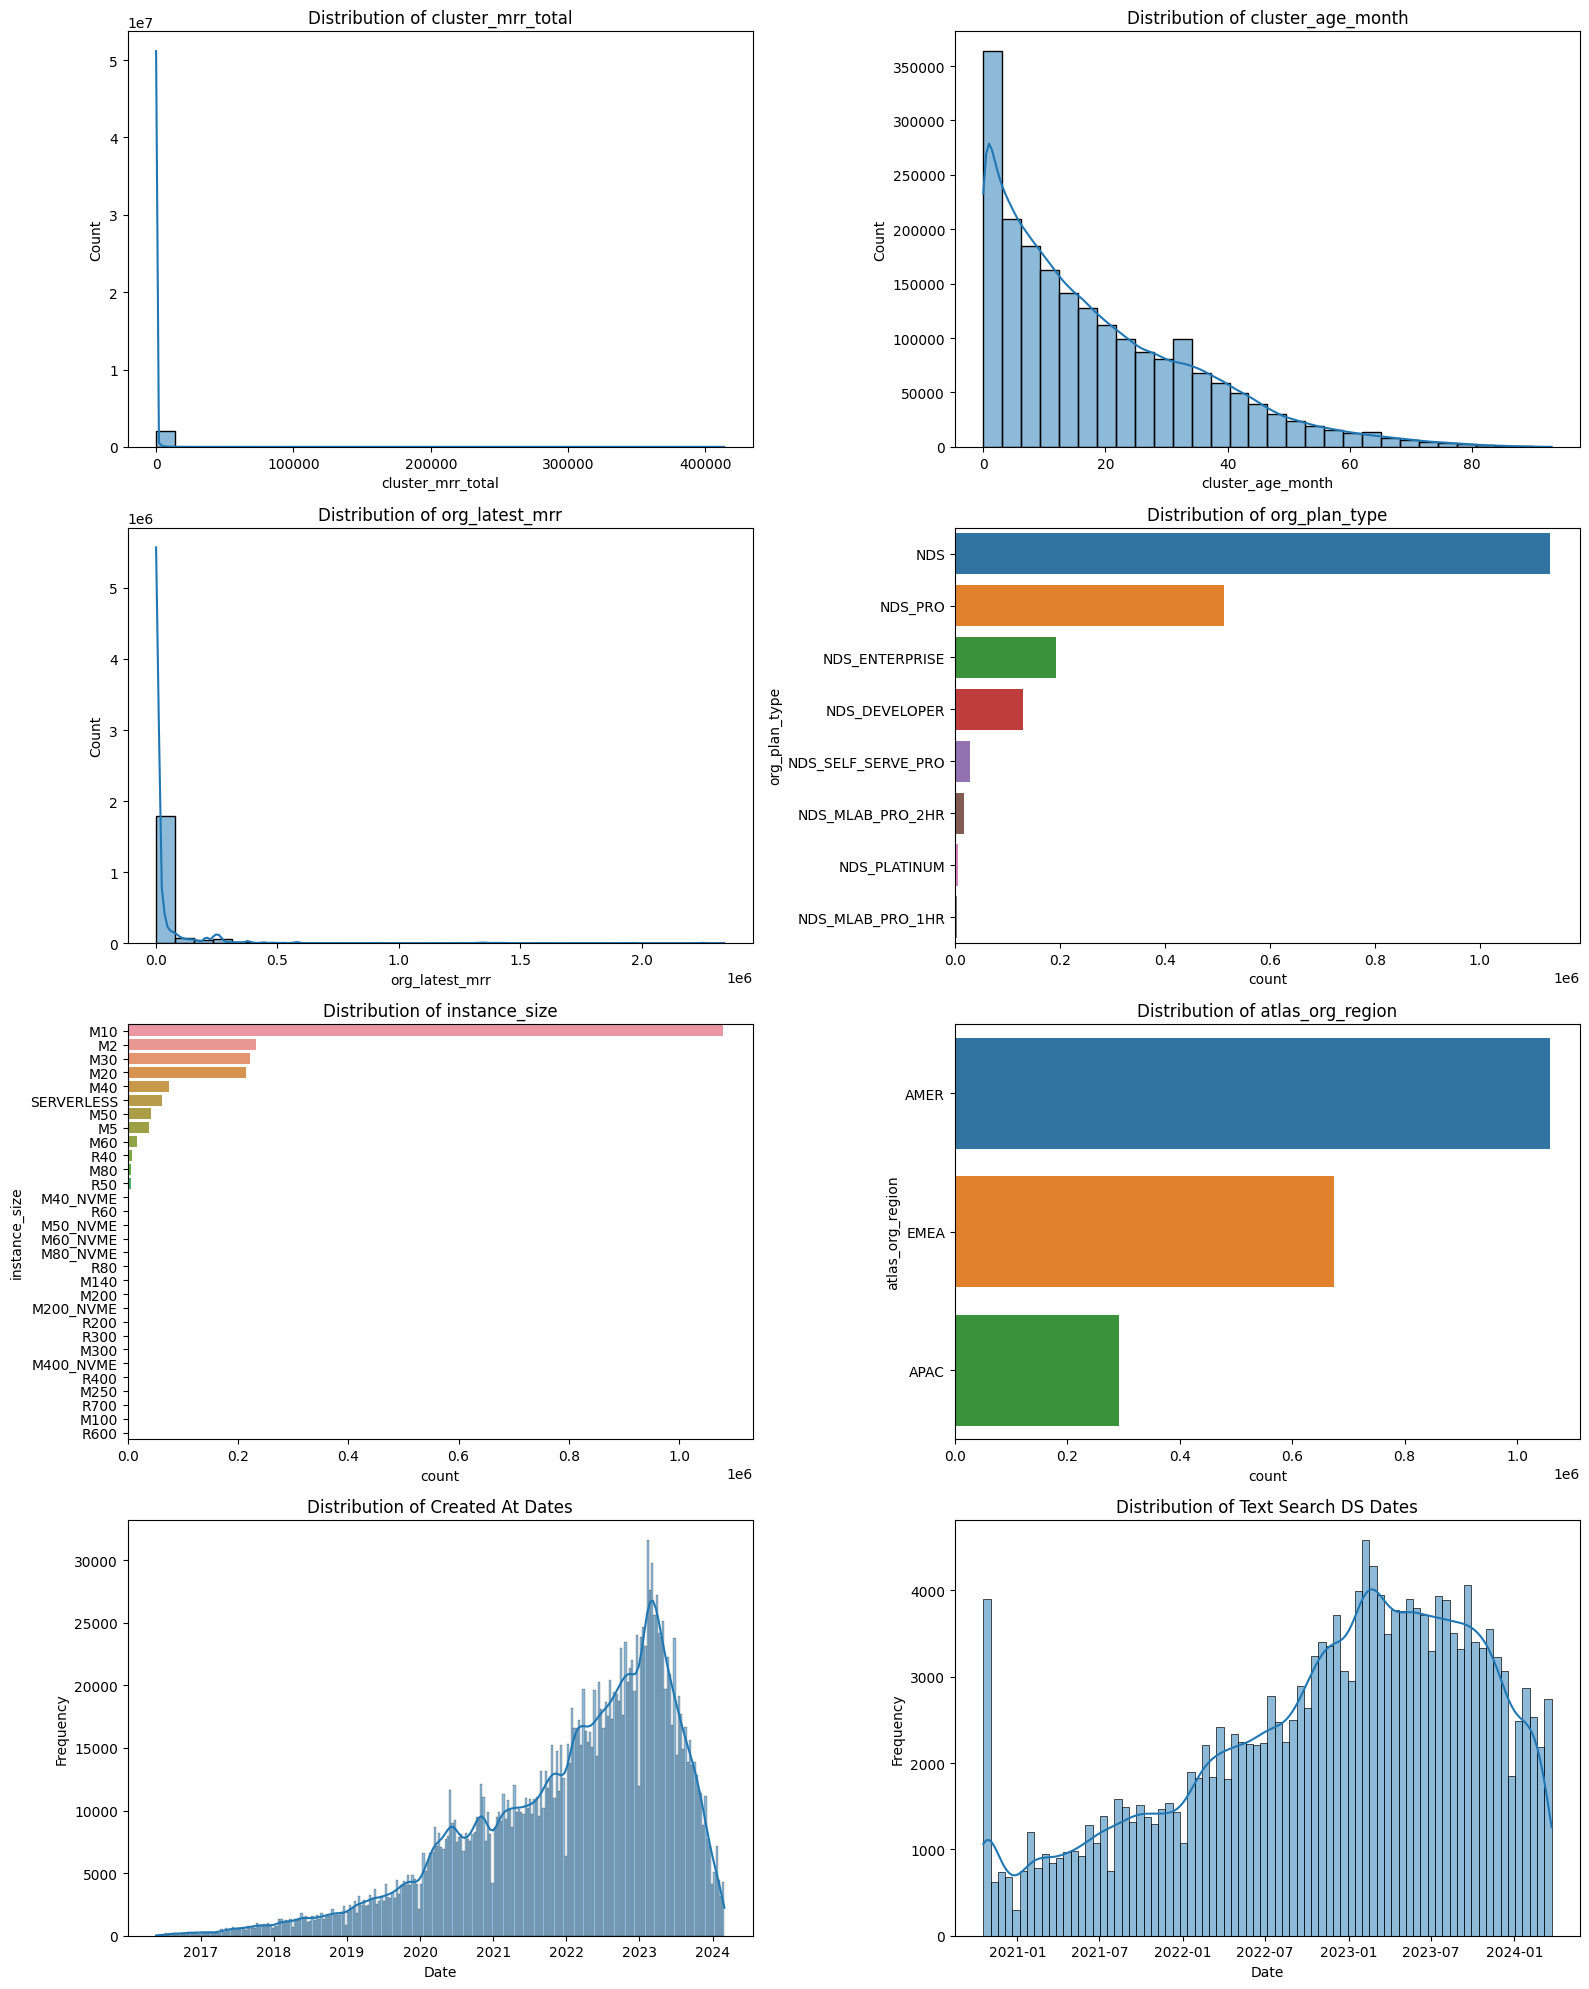

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Ensure 'created_at' and 'text_search_ds' are in datetime format for analysis
data["created_at"] = pd.to_datetime(data["created_at"])
data["text_search_ds"] = pd.to_datetime(
    data["text_search_ds"], errors="coerce"
)  # 'coerce' turns invalid data into NaT

# Convert any unhashable types in categorical variables to strings
categorical_variables = ["org_plan_type", "instance_size", "atlas_org_region"]
for column in categorical_variables:
    if any(isinstance(x, list) for x in data[column]):  # Check if any value is a list
        data[column] = data[column].apply(
            lambda x: ", ".join(x) if isinstance(x, list) else x
        )

# Prepare the layout for plotting
num_vars = ["cluster_mrr_total", "cluster_age_month", "org_latest_mrr"]
num_plots = (
    len(num_vars) + len(categorical_variables) + 2
)  # +2 for the created_at, text_search_ds plots
cols = 2
rows = num_plots // cols + (num_plots % cols > 0)

plt.figure(
    figsize=(16, max(5 * rows, 10))
)  # Adjusted the figure size to accommodate additional plots

# Plotting histograms for numerical variables
for i, var in enumerate(num_vars, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f"Distribution of {var}")

# Plotting bar plots for categorical variables
for j, var in enumerate(categorical_variables, len(num_vars) + 1):
    plt.subplot(rows, cols, j)
    order = data[var].value_counts().index
    sns.countplot(y=var, data=data, order=order)
    plt.title(f"Distribution of {var}")

# Distribution of 'created_at'
plt.subplot(rows, cols, num_plots - 1)
sns.histplot(data["created_at"].dropna(), kde=True)
plt.title("Distribution of Created At Dates")
plt.xlabel("Date")
plt.ylabel("Frequency")

# Distribution of 'text_search_ds'
plt.subplot(rows, cols, num_plots)
sns.histplot(data["text_search_ds"].dropna(), kde=True)
plt.title("Distribution of Text Search DS Dates")
plt.xlabel("Date")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [9]:
### change the chart to distinct cluster_id

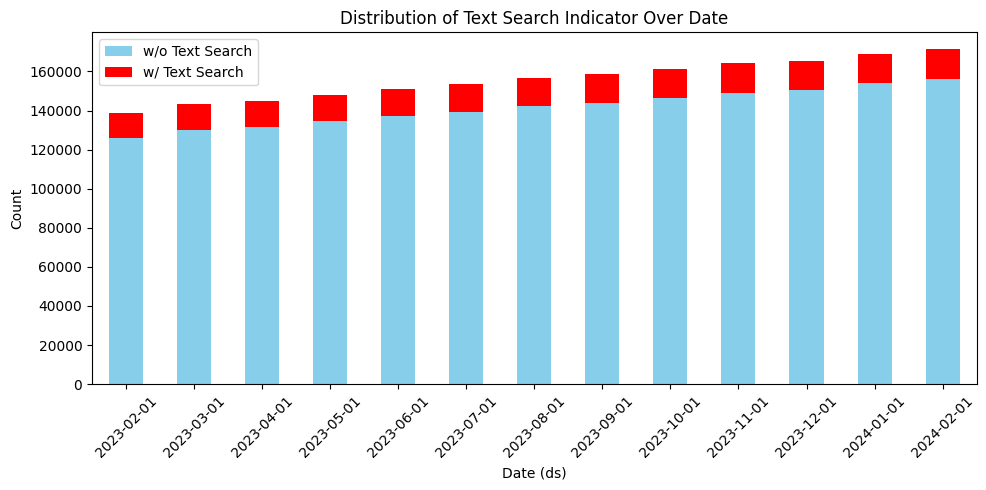

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the distribution of the 'text_search_ind' target variable over the 'ds' date
target_distribution_over_ds = (
    data.groupby("ds")["text_search_ind"].value_counts().unstack(fill_value=0)
)

# Convert the index (which is 'ds') to datetime objects first
target_distribution_over_ds.index = pd.to_datetime(target_distribution_over_ds.index)

# Now, you can safely extract the date part only to ignore the time part
target_distribution_over_ds.index = target_distribution_over_ds.index.date

# Plotting the distribution
target_distribution_over_ds.plot(
    kind="bar", stacked=True, figsize=(10, 5), color=["skyblue", "red"]
)
plt.title("Distribution of Text Search Indicator Over Date")
plt.xlabel("Date (ds)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(
    labels=["w/o Text Search", "w/ Text Search"],
    loc="upper left",
)
plt.tight_layout()
plt.grid(False)
plt.show()

# Quick Stats

### Monthly Average MRR

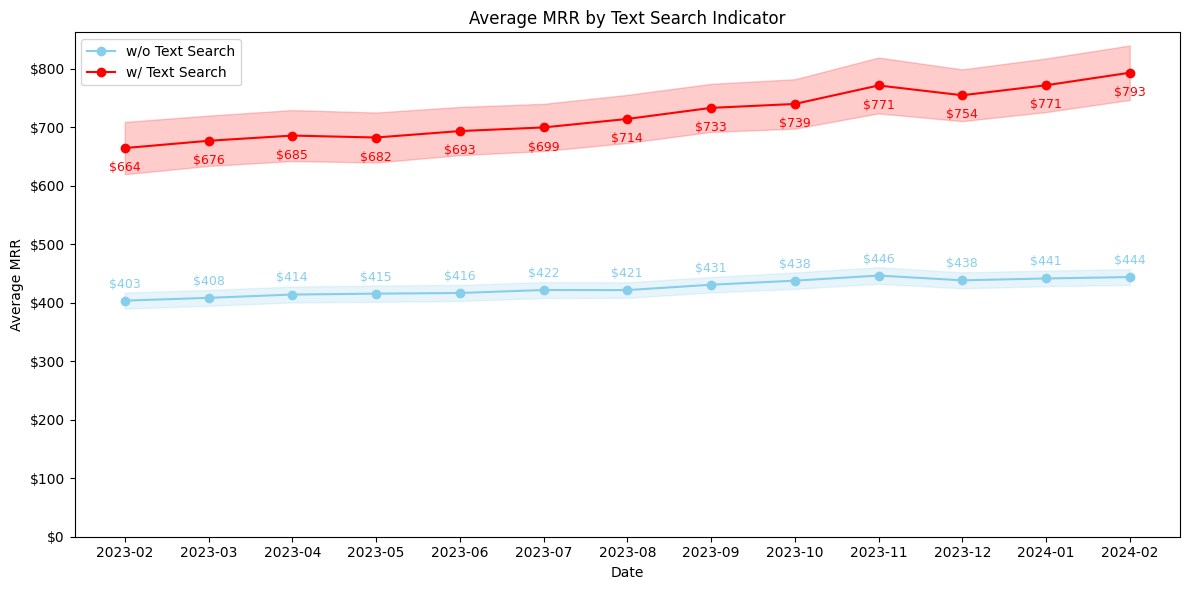

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy import stats

# Step 1: Convert 'ds' to datetime and calculate mean MRR, standard deviation, and count
# These metrics are used for confidence interval calculation and plotting.
data["ds"] = pd.to_datetime(data["ds"])
grouped_data = (
    data.groupby(["text_search_ind", "ds"])["cluster_mrr_total"]
    .agg(["mean", "std", "count"])
    .reset_index()
)


# Step 2: Define a function to calculate confidence intervals based on the standard error.
# This function calculates the 95% confidence interval for each group.
def add_ci_to_grouped_data(row):
    ci_multiplier = stats.norm.ppf(0.975)  # Z-score for 95% CI
    se = row["std"] / np.sqrt(row["count"])  # Standard error
    ci95_low = row["mean"] - (ci_multiplier * se)
    ci95_high = row["mean"] + (ci_multiplier * se)
    return pd.Series([ci95_low, ci95_high, se], index=["ci95_low", "ci95_high", "se"])


# Apply the function to calculate confidence intervals for all groups.
grouped_data[["ci95_low", "ci95_high", "se"]] = grouped_data.apply(
    add_ci_to_grouped_data, axis=1
)

# Convert 'ds' to a string format for easier plotting.
grouped_data["ds_str"] = grouped_data["ds"].dt.strftime("%Y-%m")

# Plot settings
plt.figure(figsize=(12, 6))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"${y:,.0f}"))

# Define colors and labels for each 'text_search_ind' group.
colors = ["skyblue", "red"]  # Define colors for each group
labels = ["w/o Text Search", "w/ Text Search"]  # Updated labels for legend

# Plotting each group with adjustments for data label placement
for ind, color in enumerate(colors):
    subset = grouped_data[grouped_data["text_search_ind"] == ind]
    plt.plot(
        subset["ds_str"], subset["mean"], marker="o", label=labels[ind], color=color
    )
    plt.fill_between(
        subset["ds_str"],
        subset["ci95_low"],
        subset["ci95_high"],
        alpha=0.2,
        color=color,
    )
    # Adjusting data labels for mean MRR, placing them slightly above or below the line to avoid overlap.
    label_offset = subset["mean"].max() * 0.05  # Adjust this value as needed
    for x, y in zip(subset["ds_str"], subset["mean"]):
        plt.text(
            x,
            y + label_offset if ind == 0 else y - label_offset,
            f"${y:,.0f}",
            ha="center",
            fontsize=9,
            color=color,
        )

# Final plot adjustments for clarity and aesthetics.
plt.ylim(bottom=0)  # Ensure y-axis starts from 0
plt.title("Average MRR by Text Search Indicator")
plt.xlabel("Date")
plt.ylabel("Average MRR")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Matching Process

### Assigning Treatment & Control

In [12]:
# import pandas as pd

# # Copy the original DataFrame
# data = df_raw.copy()

# # Sample 1% of unique cluster_ids, adjust sample size to at least 1 if necessary
# sampled_cluster_ids = data['cluster_id'].drop_duplicates().sample(frac=0.01, replace=False, random_state=42)

# # Filter rows where cluster_id is in the sampled list
# data = data[data['cluster_id'].isin(sampled_cluster_ids)]

# # Export to CSV
# data.to_csv("data.csv", index=False)


In [13]:
# Create a copy of the original DataFrame
data = df_raw.copy()

# Display rows
data.head()

,cluster_mrr_total,org_id,org_name,org_plan_type,group_id,group_name,group_type,is_internal_org,cluster_id,cluster_name,deployment_cluster_name,cluster_name_prefix,monitoring_cluster_id,created_at,cluster_age_month,deleted_at,cloudprovider,cloudprovider_count,region,region_count,is_cross_region,instance_size,instance_family,instance_class,tier,is_deleted,topology,replicaset_count,is_sharding,shard_count,is_global_cluster,cluster_mdb_major_version,db_version,disk_size_gb,is_multi_tenant_mongo,is_backup_enabled_cluster,is_backup_selected,backup_option,is_auto_expand_storage,is_auto_scaling_compute_enabled,is_auto_scaling_compute_scaledown_enabled,cluster_electable_node_count,cluster_readonly_node_count,cluster_secondary_node_count,cluster_analytics_node_count,is_bi_connector,bi_node_type,cluster_state,disk_iops,ebs_volume_type,connection_limit,database_limit,gb_per_week_in_limit,gb_per_week_out_limit,has_encrypted_ebs_volume,operations_per_second_limit,throttled_kb_per_second_limit,is_encryption_key_management,auto_scaling_compute_max_instance,auto_scaling_compute_min_instance,has_migrated,org_created_date,org_registration_date,org_type,org_country,org_latest_mrr,email_segment_clean,marketing_channel_group,channel_group,channel_type,account_segment,atlas_org_region,pw_language,first_cluster_instance_size,first_cluster_instance_size_group,self_serve_or_sales_sold,atlas_org_registration_date,users,system_normalized_cpu_user_monthly_daily_avg,connections_monthly_daily_avg,opcounter_cmd_monthly_daily_avg,reads_per_second_monthly_daily_avg,writes_per_second_monthly_daily_avg,document_crud_monthly_daily_avg,db_data_size_monthly_daily_avg,system_normalized_cpu_user_monthly_avg_daily_median,connections_monthly_avg_daily_median,opcounter_cmd_monthly_avg_daily_median,reads_per_second_monthly_avg_daily_median,writes_per_second_monthly_avg_daily_median,document_crud_monthly_avg_daily_median,db_data_size_avg_daily_median,ds,text_search_ds,text_search_ind
0,135.33,599eed579f78f769464d220e,Unqork,NDS_PRO,63530a458b02343de6dba3d1,unqork-nonprod-3,NDS,False,63eba04a8a71b9732c24dc2f,forward-staging,atlas-s9x2hh,forward-staging,[63eba2919c4d15023c79cce9],2023-02-14 14:52:58.791,1.00,None,[AWS],1,[US_EAST_2],1,False,M20,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,25.00,False,False,True,SNAPSHOTS,True,False,False,3.00,0.00,0.00,0.00,False,secondary,IDLE,3000.00,Gp3,NaN,NaN,NaN,NaN,None,NaN,NaN,False,None,None,False,2017-08-24 13:40:04.679,2017-06-29 19:23:51.272,NDS,US,379285.37,Business,Direct,Direct,Non-Paid,Enterprise,AMER,None,M30,Dedicated,Self Serve,2017-08-24,5.00,5.11,204.33,26.03,52.94,0.62,2.23,1275728973.87,5.14,206.03,26.06,55.72,0.64,2.19,1275937766.00,2023-03-01,None,0
1,148.04,5e9720e03c730b1f7e9d7917,Tropos,NDS_ENTERPRISE,6075bb0da047731c12db37b8,stratus-3id-pro,NDS,False,63e4cc3ce5e676324526b6f1,stratus-3id-pro,atlas-osttdu,stratus-3id-pro,[63e4cf610e5d635fb0d0f6e2],2023-02-09 10:34:36.888,1.00,None,[AWS],1,[US_EAST_1],1,False,M20,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,20.00,False,False,True,SNAPSHOTS,True,False,False,3.00,0.00,0.00,0.00,False,secondary,IDLE,3000.00,Gp3,NaN,NaN,NaN,NaN,None,NaN,NaN,True,None,None,False,2020-04-15 14:57:36.372,2017-03-10 18:21:10.424,NDS,US,208161.54,Business,Direct,Direct,Non-Paid,Enterprise,AMER,None,M10,Dedicated,Sales Sold,2020-04-15,192.00,2.61,51.44,15.42,1.73,0.18,0.94,87429219.51,2.61,51.39,15.43,1.81,0.19,0.94,87481712.87,2023-03-01,None,0
2,67.09,5b58805b4e6581400d424724,Tienda Nube,NDS_PRO,5b5883ee96e82139553af01f,Staging,NDS,False,624f3b2f042f890142266fbf,Staging-50,atlas-2b53c8,staging-50,[624f3dbf010e290bf857da03],2022-04-07 19:27:43.875,11.00,None,[AWS],1,[US_WEST_2],1,False,M10,T3,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,20.00,False,False,True,SNAPSHOTS,True,True,True,3.00,0.00,0.00,0.00,False,secondary,IDLE,3000.00,Gp3,NaN,NaN,NaN,NaN,True,NaN,NaN,False,M20,M10,False,2018-07-25 13:51:23.297,2018-07-25 13:51:23.337,NDS,US,10471.

In [14]:
### to do: try 2023-02-01 to increase sample size

In [15]:
import pandas as pd

data["ds"] = pd.to_datetime(data["ds"])
data["text_search_ds"] = pd.to_datetime(data["text_search_ds"])

# Determine the earliest text_search_ds date for each cluster
earliest_text_search = data.groupby("cluster_id")["text_search_ds"].min().reset_index()

def assign_group(row):
    # Convert string dates to datetime objects for comparison
    start_date = pd.to_datetime("2023-03-01")
    end_date = pd.to_datetime("2023-12-31")

    if pd.isnull(row['text_search_ds']):
        return "control group"
    elif row['text_search_ds'] < start_date or row['text_search_ds'] > end_date:
        return "not eligible"
    elif start_date <= row['text_search_ds'] <= end_date:
        return "treatment group"
    else:
        return "control group"

earliest_text_search['group_assignment'] = earliest_text_search.apply(assign_group, axis=1)


# Merge the group assignment back to the original dataset
data = pd.merge(
    data,
    earliest_text_search[["cluster_id", "group_assignment"]],
    on="cluster_id",
    how="left",
)

In [16]:
# Ensure 'text_search_ds' is in datetime format
data["text_search_ds"] = pd.to_datetime(data["text_search_ds"], errors="coerce")

# 1. Count of all unique clusters
total_unique_clusters = data["cluster_id"].nunique()

# 2. Count of unique clusters with 'text_search_ind' equal to 1
unique_clusters_text_search_ind_1 = data[data["text_search_ind"] == 1][
    "cluster_id"
].nunique()

# 3. Count of unique clusters with 'text_search_ds' >= '2023-03-01' and <= '2023-12-31'
unique_clusters_text_search_ds = data[
    (data["text_search_ds"] >= "2023-03-01") & (data["text_search_ds"] <= "2023-12-31")
]["cluster_id"].nunique()

# 4. Count of unique clusters in each 'group_assignment'
unique_clusters_per_group_assignment = data.groupby("group_assignment")[
    "cluster_id"
].nunique()

# Display the results
print(f"Total number of unique clusters: {total_unique_clusters}")
print(
    f"Unique clusters with 'text_search_ind' = 1: {unique_clusters_text_search_ind_1}"
)
print(
    f"Unique clusters with 'text_search_ds' >= '2023-03-01': {unique_clusters_text_search_ds}"
)
print("Unique clusters in each 'group_assignment':")
unique_clusters_per_group_assignment

Total number of unique clusters: 247167
Unique clusters with 'text_search_ind' = 1: 18299
Unique clusters with 'text_search_ds' >= '2023-03-01': 7256
Unique clusters in each 'group_assignment':


group_assignment
control group      228868
not eligible        11043
treatment group      7256
Name: cluster_id, dtype: int64

### Check Missing Values

In [17]:
columns = [
    "text_search_ind",
    "cluster_age_month",
    "org_plan_type",
    "is_cross_region",
    "instance_size",
    "topology",
    "cluster_mdb_major_version",
    "disk_size_gb",
    "org_country",
    "org_latest_mrr",
    "email_segment_clean",
    "marketing_channel_group",
    "account_segment",
    "self_serve_or_sales_sold",
    "reads_per_second_monthly_daily_avg",
    "writes_per_second_monthly_daily_avg",
    "connections_monthly_daily_avg",
    "opcounter_cmd_monthly_daily_avg",
    "db_data_size_monthly_daily_avg",
    "ds",
]

missing_values = (
    data[columns].groupby("text_search_ind").apply(lambda x: x.isnull().sum())
)

missing_values

,text_search_ind,cluster_age_month,org_plan_type,is_cross_region,instance_size,topology,cluster_mdb_major_version,disk_size_gb,org_country,org_latest_mrr,email_segment_clean,marketing_channel_group,account_segment,self_serve_or_sales_sold,reads_per_second_monthly_daily_avg,writes_per_second_monthly_daily_avg,connections_monthly_daily_avg,opcounter_cmd_monthly_daily_avg,db_data_size_monthly_daily_avg,ds
text_search_ind,,,,,,,,,,,,,,,,,,,,
0,0,32,0,0,0,32,0,0,637,4006,113,113,4191,113,64037,64037,64181,64326,64037,0
1,0,1,0,0,0,1,0,0,77,239,10,10,274,10,40,40,45,49,40,0


In [18]:
# Calculate the percentage of rows with any missing value, grouped by 'text_search_ind'
percentage_missing = (
    data[columns].isnull().any(axis=1).groupby(data["text_search_ind"]).mean() * 100
)

# Format the output with a '%' sign
percentage_missing.apply(lambda x: f"{x:.2f}%")

text_search_ind
0    3.81%
1    0.30%
dtype: object

### PS Matching

In [19]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from imblearn.over_sampling import SMOTE
# from scipy.spatial.distance import cdist
# import xgboost as xgb

# # Ensure 'ds' and 'text_search_ds' are in datetime format
# data["ds"] = pd.to_datetime(data["ds"])
# data["text_search_ds"] = pd.to_datetime(data["text_search_ds"])

# # Filter rows where 'ds' is between 2023-03-01 and 2023-12-31, and 'group_assignment' is not 'not eligible'
# data = data[(data["group_assignment"] != "not eligible") & 
#             (data["ds"] >= pd.to_datetime("2023-03-01")) & 
#             (data["ds"] <= pd.to_datetime("2023-12-31"))].copy()

# # Create a new column to indicate if 'text_search_ds' and 'ds' are in the same month
# data["same_month_indicator"] = (
#     (data["ds"].dt.year == data["text_search_ds"].dt.year)
#     & (data["ds"].dt.month == data["text_search_ds"].dt.month)
# ).astype(int)

# # Convert 'ds' to datetime to extract month-year combination for monthly analysis
# data["month_year"] = data["ds"].dt.to_period("M")

# # Set 'text_search_month_indicator' to 1 if 'text_search_ds' is not null and occurs in the same month as 'ds' or earlier, else 0.
# data["text_search_month_indicator"] = (
#     data["text_search_ds"].notnull() &
#     (data["text_search_ds"].dt.to_period('M') <= data["ds"].dt.to_period('M'))
# ).astype(int)

# # Define columns to work with including features and target variable
# feature_columns = [
#     "cluster_age_month",
#     "org_plan_type",
#     "is_cross_region",
#     "instance_size",
#     "topology",
#     "cluster_mdb_major_version",
#     "disk_size_gb",
#     "org_country",
#     "org_latest_mrr",
#     "email_segment_clean",
#     "marketing_channel_group",
#     "account_segment",
#     "self_serve_or_sales_sold",
#     "reads_per_second_monthly_daily_avg",
#     "writes_per_second_monthly_daily_avg",
#     "connections_monthly_daily_avg",
#     "opcounter_cmd_monthly_daily_avg",
#     "db_data_size_monthly_daily_avg",
# ]

# # Drop rows with any null values in these columns
# data.dropna(subset=feature_columns, inplace=True)

# # Encode categorical variables
# for column in feature_columns:
#     if data[column].dtype == "object":
#         le = LabelEncoder()
#         data[column] = le.fit_transform(data[column].astype(str))

# # Initialize the scaler and standardize numerical fields
# scaler = StandardScaler()
# data[feature_columns] = scaler.fit_transform(data[feature_columns])

# # Initialize SMOTE instance
# smote = SMOTE(random_state=42)

# matched_pairs_list = []  # Prepare to collect matched row data
# pair_indices = []  # Prepare to collect indices indicating paired rows

# pair_index = 0  # Initialize pair index

# for period in data["month_year"].unique():
#     subset = data[data["month_year"] == period].copy()

#     # Separate features and the newly defined target variable
#     X = subset[feature_columns]
#     target_variable = subset["text_search_month_indicator"]

#     # Apply SMOTE to balance the dataset
#     X_smote, target_variable_smote = smote.fit_resample(X, target_variable)

#     # Initialize and fit the XGBoost model
#     xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
#     xgb_model.fit(X_smote, target_variable_smote)

#     # Calculate propensity scores for the original dataset
#     propensity_scores = xgb_model.predict_proba(X)[:, 1]

#     # Perform matching
#     treatment_indices = subset[subset["group_assignment"] == 'treatment group'].index
#     control_indices = subset[subset["group_assignment"] == 'control group'].index

#     # Calculate the distance matrix and find closest matches
#     distance_matrix = cdist(
#         propensity_scores[subset["group_assignment"] == 'treatment group'].reshape(-1, 1),
#         propensity_scores[subset["group_assignment"] == 'control group'].reshape(-1, 1),
#         metric="euclidean",
#     )
#     closest_indices = np.argmin(distance_matrix, axis=1)

#     # Match control indices to treatment indices based on minimum distance
#     matched_control_indices = control_indices[closest_indices]

#     for t, c in zip(treatment_indices, matched_control_indices):
#         matched_pairs_list.append(subset.loc[t])
#         matched_pairs_list.append(subset.loc[c])
#         # Add the current pair index for both the treatment and control unit
#         pair_indices += [pair_index, pair_index]  # Append the same index for both in the pair
#         pair_index += 1  # Increment the pair index for the next pair

# # Convert the list of matched rows into a DataFrame
# matched_rows = pd.DataFrame(matched_pairs_list).reset_index(drop=True)

# # Add the pair index to the matched rows DataFrame
# matched_rows['pair_index'] = pair_indices

# # Filter treatment rows where 'same_month_indicator' is 1 and get unique pair indices
# treatment_pair_indices = matched_rows[matched_rows['same_month_indicator'] == 1]['pair_index'].unique()

# # Use these indices to select both treatment and control rows from the matched dataset
# final_dataset = matched_rows[matched_rows['pair_index'].isin(treatment_pair_indices)]


In [20]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from imblearn.over_sampling import SMOTE
# from scipy.spatial.distance import cdist
# import xgboost as xgb

# # Ensure 'ds' and 'text_search_ds' are in datetime format
# data["ds"] = pd.to_datetime(data["ds"])
# data["text_search_ds"] = pd.to_datetime(data["text_search_ds"])

# # Filter rows where 'ds' is between 2023-03-01 and 2023-12-31, and 'group_assignment' is not 'not eligible'
# data = data[(data["group_assignment"] != "not eligible") & 
#             (data["ds"] >= pd.to_datetime("2023-03-01")) & 
#             (data["ds"] <= pd.to_datetime("2023-12-31"))]

# # Create a new column to indicate if 'text_search_ds' and 'ds' are in the same month
# data["same_month_indicator"] = (
#     (data["ds"].dt.year == data["text_search_ds"].dt.year)
#     & (data["ds"].dt.month == data["text_search_ds"].dt.month)
# ).astype(int)

# # Convert 'ds' to datetime to extract month-year combination for monthly analysis
# data["month_year"] = data["ds"].dt.to_period("M")

# # Set 'text_search_month_indicator' to 1 if 'text_search_ds' is not null and 
# # occurs in the same month as 'ds' or earlier, else 0.
# data["text_search_month_indicator"] = (
#     data["text_search_ds"].notnull() &
#     (data["text_search_ds"].dt.to_period('M') <= data["ds"].dt.to_period('M'))
# ).astype(int)

# # Define columns to work with including features and target variable
# feature_columns = [
#     "cluster_age_month",
#     "org_plan_type",
#     "is_cross_region",
#     "instance_size",
#     "topology",
#     "cluster_mdb_major_version",
#     "disk_size_gb",
#     "org_country",
#     "org_latest_mrr",
#     "email_segment_clean",
#     "marketing_channel_group",
#     "account_segment",
#     "self_serve_or_sales_sold",
#     "reads_per_second_monthly_daily_avg",
#     "writes_per_second_monthly_daily_avg",
#     "connections_monthly_daily_avg",
#     "opcounter_cmd_monthly_daily_avg",
#     "db_data_size_monthly_daily_avg",
# ]

# # Drop rows with any null values in these columns
# data.dropna(subset=feature_columns, inplace=True)


# # Encode categorical variables
# for column in feature_columns:
#     if data[column].dtype == "object":
#         le = LabelEncoder()
#         data[column] = le.fit_transform(data[column].astype(str))

# # Initialize the scaler and standardize numerical fields
# scaler = StandardScaler()
# data[feature_columns] = scaler.fit_transform(data[feature_columns])

# # Initialize SMOTE instance
# smote = SMOTE(random_state=42)

# # Placeholder for refined matched pairs and their indices
# refined_matched_pairs_list = []
# pair_indices = []

# pair_index = 0  # Initialize pair index

# # Define a propensity score (PS) tolerance range for initial matching
# ps_tolerance = 0.05  # Example tolerance

# for period in data["month_year"].unique():
#     subset = data[data["month_year"] == period].copy()

#     # Separate features and the newly defined target variable
#     X = subset[feature_columns]
#     y = subset["text_search_month_indicator"]

#     # Apply SMOTE to balance the dataset
#     X_resampled, y_resampled = smote.fit_resample(X, y)

#     # Initialize and fit the XGBoost model
#     xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
#     xgb_model.fit(X_resampled, y_resampled)

#     # Calculate propensity scores for the original dataset
#     subset['propensity_score'] = xgb_model.predict_proba(X)[:, 1]

#     # Split into treatment and control groups
#     treatment = subset[subset['group_assignment'] == 'treatment group']
#     control = subset[subset['group_assignment'] == 'control group']

#     for index, treatment_row in treatment.iterrows():
#         # Filter potential matches from control group based on propensity score tolerance
#         potential_matches = control[
#             (control['propensity_score'] >= treatment_row['propensity_score'] - ps_tolerance) &
#             (control['propensity_score'] <= treatment_row['propensity_score'] + ps_tolerance)
#         ].copy()  # Work on a copied slice to avoid SettingWithCopyWarning

#         # If there are potential matches, refine based on the closest 'cluster_mrr_total'
#         if not potential_matches.empty:
#             potential_matches['mrr_distance'] = np.abs(potential_matches['cluster_mrr_total'] - treatment_row['cluster_mrr_total'])
#             closest_match_index = potential_matches['mrr_distance'].idxmin()
#             closest_match = potential_matches.loc[closest_match_index]

#             # Add to the matched pairs list
#             refined_matched_pairs_list.append(treatment_row)
#             refined_matched_pairs_list.append(closest_match)

#             # Add pair index for matching
#             pair_indices.extend([pair_index, pair_index])
#             pair_index += 1

#             # Remove the matched control from further consideration
#             control = control.drop(closest_match_index)

# # Convert the list of matched rows into a DataFrame
# matched_rows = pd.DataFrame(refined_matched_pairs_list).reset_index(drop=True)

# # Add the pair index to the matched rows DataFrame
# matched_rows['pair_index'] = pair_indices

# # Filter treatment rows where 'same_month_indicator' is 1 and get unique pair indices
# treatment_pair_indices = matched_rows[matched_rows['same_month_indicator'] == 1]['pair_index'].unique()

# # Use these indices to select both treatment and control rows from the matched dataset
# final_dataset = matched_rows[matched_rows['pair_index'].isin(treatment_pair_indices)]

### Exact + Fuzzy Match

In [21]:
import pandas as pd
import numpy as np

# Convert 'ds' and 'text_search_ds' to datetime format in one step
data[["ds", "text_search_ds"]] = data[["ds", "text_search_ds"]].apply(pd.to_datetime)

# Define the filtering conditions in advance to improve readability
eligible = data["group_assignment"] != "not eligible"
date_range = (data["ds"] >= "2023-03-01") & (data["ds"] <= "2023-12-31")
not_deleted = data["is_deleted"] != True  # Add not deleted filter
mrr_greater_than_zero = data["cluster_mrr_total"] > 0  # Add MRR > 0 filter

# Apply all filtering conditions
data = data[eligible & date_range & not_deleted & mrr_greater_than_zero]

# Use a single line to create 'same_month_indicator' by comparing years and months directly
data["same_month_indicator"] = ((data["ds"].dt.to_period("M") == data["text_search_ds"].dt.to_period("M"))).astype(int)

# Convert 'ds' to a 'month_year' period format for monthly analysis directly
data["month_year"] = data["ds"].dt.to_period("M")

# Set 'text_search_month_indicator' using period comparison for simplicity
data["text_search_month_indicator"] = (data["text_search_ds"].notnull() & (data["text_search_ds"].dt.to_period('M') <= data["month_year"])).astype(int)

In [22]:
import pandas as pd

base_match_variable = 'month_year'
final_refine_variable = 'cluster_mrr_total'
categorical_variables = ['instance_size', 'topology']
numerical_variables = ['cluster_age_month']

data['pair_index'] = pd.NA  # Initialize pairing index
global_pair_index = 0  # Start with a global unique index

# Iterate over each unique 'month_year' to first remove outliers based on 'cluster_mrr_total'
unique_months = data[base_match_variable].drop_duplicates()

for month in unique_months:
    # Filter data for the current month
    month_data = data[data[base_match_variable] == month]

    # Remove outliers within 'cluster_mrr_total' for the current month
    Q1 = month_data[final_refine_variable].quantile(0.25)
    Q3 = month_data[final_refine_variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_month_data = month_data[(month_data[final_refine_variable] >= lower_bound) & (month_data[final_refine_variable] <= upper_bound)]

    unique_combinations = filtered_month_data[categorical_variables].drop_duplicates()
    for _, combo in unique_combinations.iterrows():
        combo_filter = filtered_month_data[categorical_variables].eq(combo).all(axis=1)
        combo_data = filtered_month_data[combo_filter]

        treatment_data = combo_data[(combo_data['group_assignment'] == 'treatment group') & (combo_data['same_month_indicator'] == 1)]
        control_data = combo_data[combo_data['group_assignment'] == 'control group']

        for t_index, t_row in treatment_data.iterrows():
            potential_matches = control_data.copy()
            
            for var in numerical_variables:
                potential_matches = potential_matches[abs(potential_matches[var] - t_row[var]) <= 1]
            
            if not potential_matches.empty:
                potential_matches['difference'] = abs(potential_matches[final_refine_variable] - t_row[final_refine_variable])
                closest_match_index = potential_matches['difference'].idxmin()

                # Update pair_index for matched pairs directly in the original DataFrame
                data.at[t_index, 'pair_index'] = global_pair_index
                data.at[closest_match_index, 'pair_index'] = global_pair_index
                global_pair_index += 1  # Increment for the next pair
                
                # Ensure the matched control entry is not reused
                control_data = control_data.drop(closest_match_index)

# Finalize matched pairs, converting 'pair_index', and filtering unmatched entries
data['pair_index'] = data['pair_index'].astype('Int64')
matched_data = data.dropna(subset=['pair_index'])

# Filter to refine final matched dataset based on specific criteria
final_matched_dataset = matched_data[matched_data['pair_index'].isin(
    matched_data[(matched_data['group_assignment'] == 'treatment group') & 
                 (matched_data['same_month_indicator'] == 1)]['pair_index']
)]


### Balance Check

In [23]:
# Update: Use final_matched_dataset for calculations

# Calculate unique clusters in the treatment group from original data
unique_clusters_treatment_original = final_matched_dataset[final_matched_dataset['group_assignment'] == 'treatment group']['cluster_id'].nunique()
print(f"Unique clusters in treatment: {unique_clusters_treatment_original}")

# Calculate unique clusters in both groups from final_matched_dataset
unique_clusters_treatment_final = final_matched_dataset[final_matched_dataset['group_assignment'] == 'treatment group']['cluster_id'].nunique()
unique_clusters_control_final = final_matched_dataset[final_matched_dataset['group_assignment'] == 'control group']['cluster_id'].nunique()
print(f"Unique clusters in treatment: {unique_clusters_treatment_final}, control: {unique_clusters_control_final}")

# Calculate total cluster counts in both groups
total_clusters_treatment_final = final_matched_dataset[final_matched_dataset['group_assignment'] == 'treatment group']['cluster_id'].count()
total_clusters_control_final = final_matched_dataset[final_matched_dataset['group_assignment'] == 'control group']['cluster_id'].count()
print(f"Total clusters in treatment: {total_clusters_treatment_final}, control: {total_clusters_control_final}")


Unique clusters in treatment: 5393
Unique clusters in treatment: 5393, control: 5282
Total clusters in treatment: 5393, control: 5393


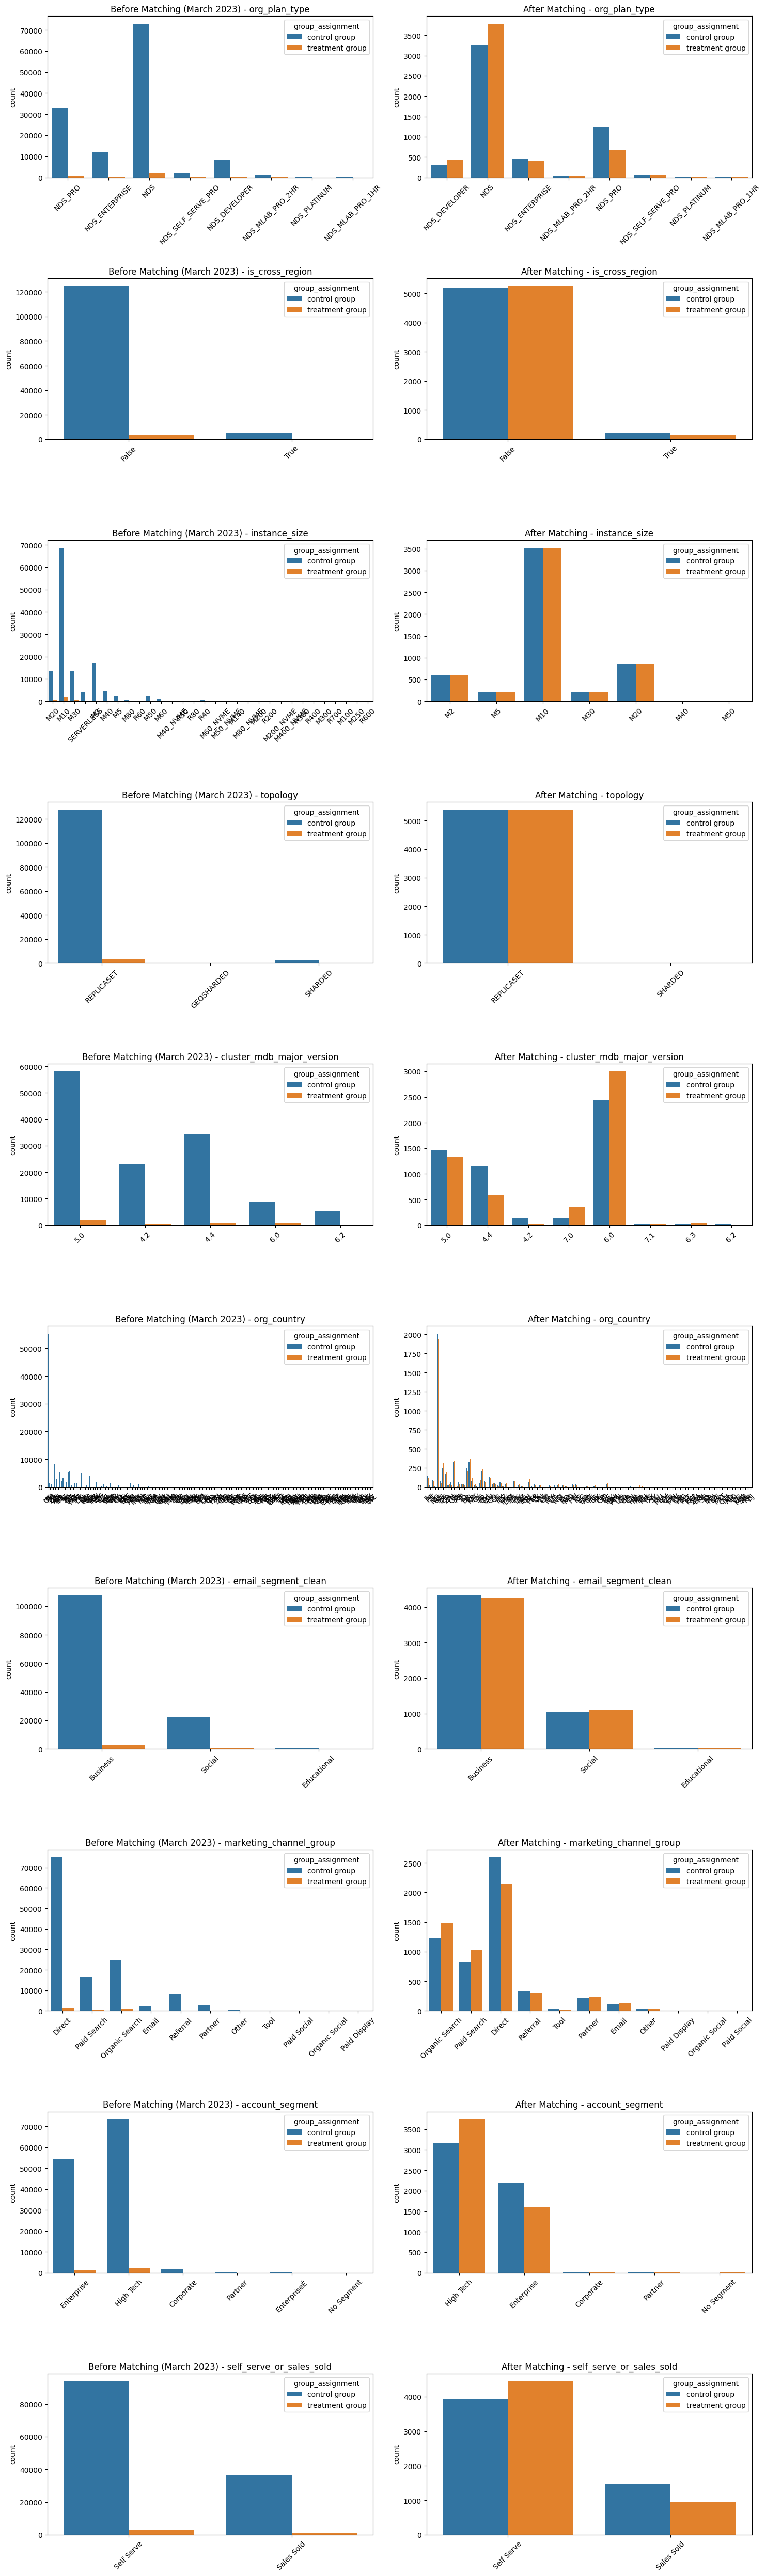

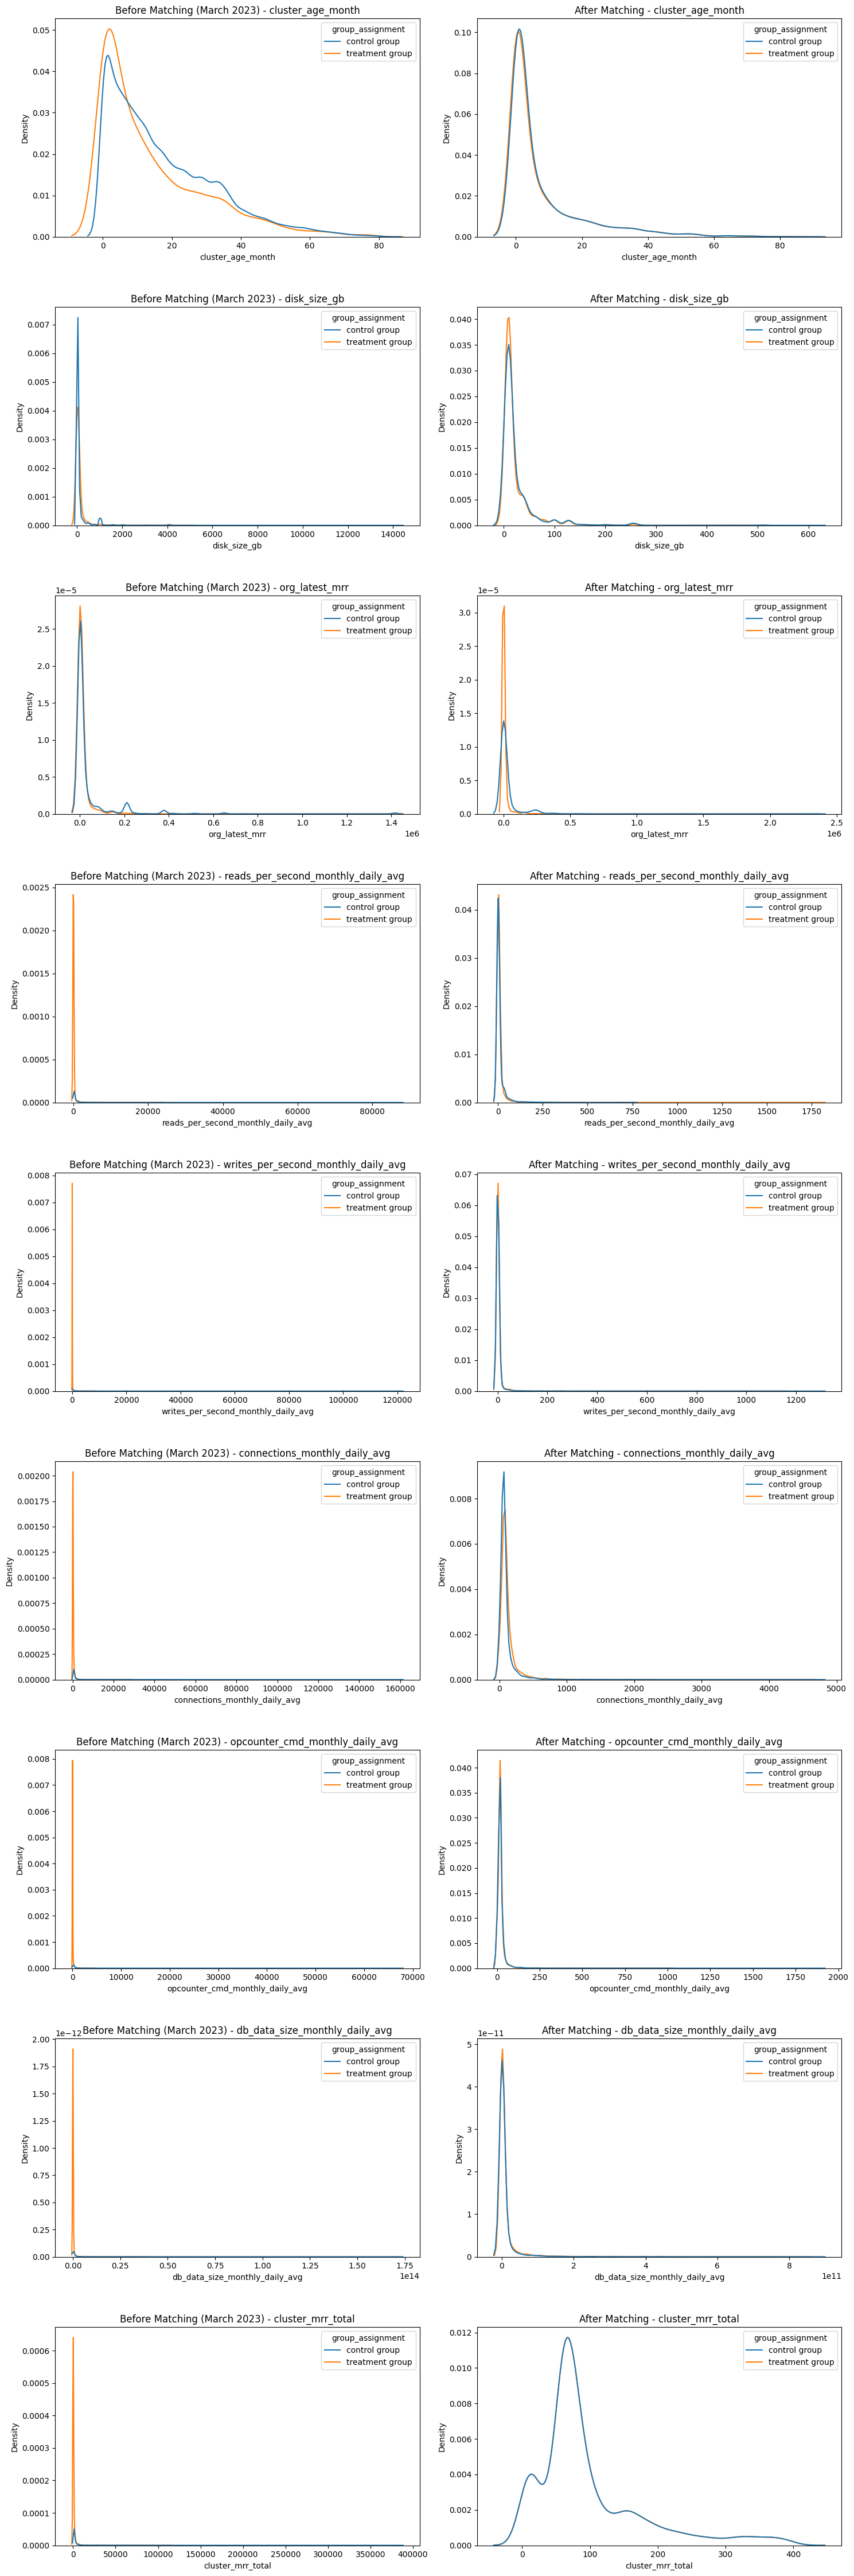

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical and numerical features
categorical_features = [
    "org_plan_type",
    "is_cross_region",
    "instance_size",
    "topology",
    "cluster_mdb_major_version",
    "org_country",
    "email_segment_clean",
    "marketing_channel_group",
    "account_segment",
    "self_serve_or_sales_sold"
]

numerical_features = [
    "cluster_age_month",
    "disk_size_gb",
    "org_latest_mrr",
    "reads_per_second_monthly_daily_avg",
    "writes_per_second_monthly_daily_avg",
    "connections_monthly_daily_avg",
    "opcounter_cmd_monthly_daily_avg",
    "db_data_size_monthly_daily_avg",
    "cluster_mrr_total"
]

# Filter data for March 2023
march_2023_data = data[(data['ds'].dt.year == 2023) & (data['ds'].dt.month == 3) &
                       ((data['group_assignment'] == 'treatment group') | (data['group_assignment'] == 'control group'))]

# Plotting categorical features with count plots
fig, axes = plt.subplots(len(categorical_features), 2, figsize=(15, 5 * len(categorical_features)), squeeze=False)
for i, feature in enumerate(categorical_features):
    # Before Matching - March 2023 Data
    sns.countplot(x=feature, hue='group_assignment', data=march_2023_data, ax=axes[i, 0])
    axes[i, 0].set_title(f'Before Matching (March 2023) - {feature}')
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].set_xlabel('')  # Remove x-label to save space
    
    # After Matching
    sns.countplot(x=feature, hue='group_assignment', data=final_matched_dataset, ax=axes[i, 1])
    axes[i, 1].set_title(f'After Matching - {feature}')
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].set_xlabel('')  # Remove x-label to save space

plt.tight_layout(h_pad=3)  # Adjust vertical spacing to prevent overlap
plt.show()

# Now, plotting numerical features with KDE plots
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(15, 5 * len(numerical_features)), squeeze=False)
for i, feature in enumerate(numerical_features):
    # Before Matching - March 2023 Data
    sns.kdeplot(data=march_2023_data, x=feature, hue='group_assignment', ax=axes[i, 0], common_norm=False)
    axes[i, 0].set_title(f'Before Matching (March 2023) - {feature}')
    
    # After Matching
    sns.kdeplot(data=final_matched_dataset, x=feature, hue='group_assignment', ax=axes[i, 1], common_norm=False)
    axes[i, 1].set_title(f'After Matching - {feature}')

plt.tight_layout(h_pad=3)
plt.show()


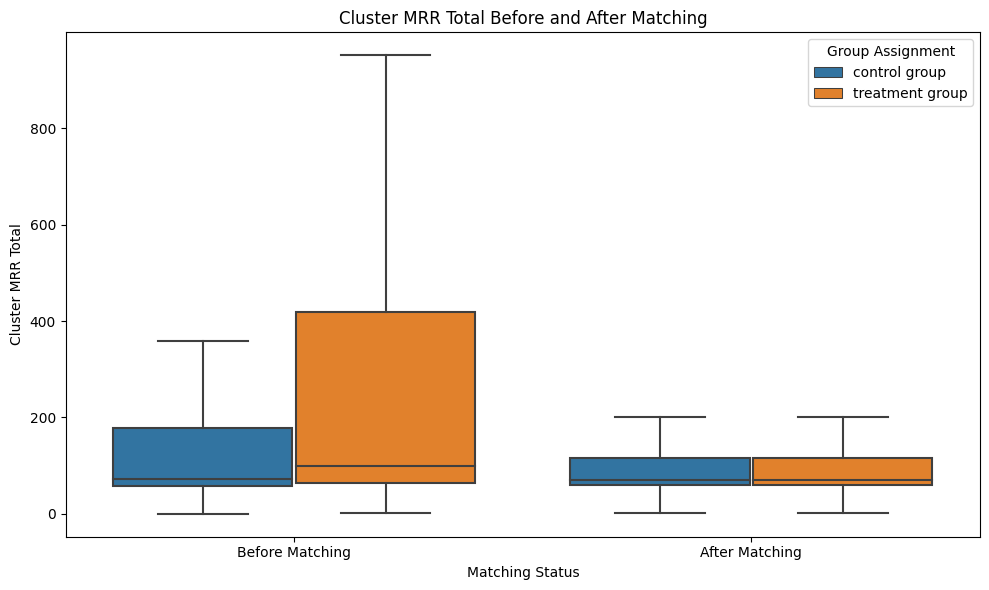

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for '2023-03-01' in 'data' for before matching, and use 'final_matched_dataset' for after matching
before_matching_data = data[data['ds'] == '2023-03-01'][['group_assignment', 'cluster_mrr_total']].copy()
before_matching_data['Match_Status'] = 'Before Matching'

after_matching_data = final_matched_dataset[['group_assignment', 'cluster_mrr_total']].copy()
after_matching_data['Match_Status'] = 'After Matching'

# Combine and plot without outliers
combined_data = pd.concat([before_matching_data, after_matching_data])
plt.figure(figsize=(10, 6))
sns.boxplot(x='Match_Status', y='cluster_mrr_total', hue='group_assignment', data=combined_data, showfliers=False)
plt.title('Cluster MRR Total Before and After Matching')
plt.xlabel('Matching Status')
plt.ylabel('Cluster MRR Total')
plt.legend(title='Group Assignment')
plt.tight_layout()
plt.show()


# Data Pipeline

In [26]:
# import pandas as pd

# # Copy df_raw to avoid altering the original DataFrame
# data = df_raw.copy()

# # Convert 'ds' columns in both datasets to datetime objects, if not already done
# final_matched_dataset['ds'] = pd.to_datetime(final_matched_dataset['ds'])
# data['ds'] = pd.to_datetime(data['ds'])

# # Merge final_matched_dataset with data on 'cluster_id'
# merged_data = pd.merge(final_matched_dataset[['cluster_id', 'ds']], data[['cluster_id', 'ds', 'cluster_mrr_total']], on='cluster_id', how='left', suffixes=('_final', '_data'))

# # Ensure 'ds_final' and 'ds_data' are datetime types after merge, to avoid AttributeError
# merged_data['ds_final'] = pd.to_datetime(merged_data['ds_final'])
# merged_data['ds_data'] = pd.to_datetime(merged_data['ds_data'])

# # Filter to include records where 'ds_data' is equal or after 'ds_final'
# filtered_data = merged_data[merged_data['ds_data'] >= merged_data['ds_final']].copy()

# # Calculate the month difference
# filtered_data['month_diff'] = ((filtered_data['ds_data'].dt.year - filtered_data['ds_final'].dt.year) * 12 + filtered_data['ds_data'].dt.month - filtered_data['ds_final'].dt.month)

# # Pivot the table based on 'month_diff'
# pivot_mrr_totals = filtered_data.pivot_table(index='cluster_id', columns='month_diff', values='cluster_mrr_total', aggfunc='first').reset_index()

# # Flatten the columns and rename them to "Month X" format
# pivot_mrr_totals.columns = ['cluster_id'] + [f'Month {col}' for col in pivot_mrr_totals.columns if isinstance(col, int)]

# # Merge the pivot table back into final_matched_dataset
# final_dataset_with_monthly_mrr = pd.merge(final_matched_dataset, pivot_mrr_totals, on='cluster_id', how='left')

# # Check the result
# final_dataset_with_monthly_mrr.head()

In [27]:
import pandas as pd
from datetime import datetime

# Copy df_raw to avoid altering the original DataFrame
data = df_raw.copy()

# Convert 'ds' columns in both datasets to datetime objects, if not already done
final_matched_dataset['ds'] = pd.to_datetime(final_matched_dataset['ds'])
df_raw['ds'] = pd.to_datetime(df_raw['ds'])

# Merge final_matched_dataset with df_raw on 'cluster_id'
merged_data = pd.merge(final_matched_dataset[['cluster_id', 'ds']], df_raw[['cluster_id', 'ds', 'cluster_mrr_total']], on='cluster_id', how='left', suffixes=('_final', '_data'))

# Ensure 'ds_final' and 'ds_data' are datetime types after merge, to avoid AttributeError
merged_data['ds_final'] = pd.to_datetime(merged_data['ds_final'])
merged_data['ds_data'] = pd.to_datetime(merged_data['ds_data'])

# Filter to include records where 'ds_data' is equal or after 'ds_final'
filtered_data = merged_data[merged_data['ds_data'] >= merged_data['ds_final']].copy()

# Calculate the month difference
filtered_data['month_diff'] = ((filtered_data['ds_data'].dt.year - filtered_data['ds_final'].dt.year) * 12 + filtered_data['ds_data'].dt.month - filtered_data['ds_final'].dt.month)

# Pivot the table based on 'month_diff'
pivot_mrr_totals = filtered_data.pivot_table(index='cluster_id', columns='month_diff', values='cluster_mrr_total', aggfunc='first').reset_index()

# Flatten the columns and rename them to "Month X" format
pivot_mrr_totals.columns = ['cluster_id'] + [f'Month {col}' for col in pivot_mrr_totals.columns if isinstance(col, int)]

# Merge the pivot table back into final_matched_dataset
final_dataset_with_monthly_mrr = pd.merge(final_matched_dataset, pivot_mrr_totals, on='cluster_id', how='left')

# Imputation step
fixed_date = datetime(2024, 2, 1)
mrr_columns = [col for col in final_dataset_with_monthly_mrr.columns if col.startswith('Month')]

def impute_mrr(row, fixed_date, mrr_columns):
    for col in mrr_columns:
        # Extract the month number from the column name
        month_num = int(col.split(' ')[1])
        # Calculate month difference from fixed_date to ds
        month_diff = (fixed_date.year - row['ds'].year) * 12 + fixed_date.month - row['ds'].month
        # Impute based on condition
        if pd.isnull(row[col]):
            if month_num <= month_diff:
                row[col] = 0
    return row

# Apply the imputation row-wise
final_dataset_with_monthly_mrr = final_dataset_with_monthly_mrr.apply(lambda row: impute_mrr(row, fixed_date, mrr_columns), axis=1)

# Display the result
final_dataset_with_monthly_mrr.head()

,cluster_mrr_total,org_id,org_name,org_plan_type,group_id,group_name,group_type,is_internal_org,cluster_id,cluster_name,deployment_cluster_name,cluster_name_prefix,monitoring_cluster_id,created_at,cluster_age_month,deleted_at,cloudprovider,cloudprovider_count,region,region_count,is_cross_region,instance_size,instance_family,instance_class,tier,is_deleted,topology,replicaset_count,is_sharding,shard_count,is_global_cluster,cluster_mdb_major_version,db_version,disk_size_gb,is_multi_tenant_mongo,is_backup_enabled_cluster,is_backup_selected,backup_option,is_auto_expand_storage,is_auto_scaling_compute_enabled,is_auto_scaling_compute_scaledown_enabled,cluster_electable_node_count,cluster_readonly_node_count,cluster_secondary_node_count,cluster_analytics_node_count,is_bi_connector,bi_node_type,cluster_state,disk_iops,ebs_volume_type,...,org_registration_date,org_type,org_country,org_latest_mrr,email_segment_clean,marketing_channel_group,channel_group,channel_type,account_segment,atlas_org_region,pw_language,first_cluster_instance_size,first_cluster_instance_size_group,self_serve_or_sales_sold,atlas_org_registration_date,users,system_normalized_cpu_user_monthly_daily_avg,connections_monthly_daily_avg,opcounter_cmd_monthly_daily_avg,reads_per_second_monthly_daily_avg,writes_per_second_monthly_daily_avg,document_crud_monthly_daily_avg,db_data_size_monthly_daily_avg,system_normalized_cpu_user_monthly_avg_daily_median,connections_monthly_avg_daily_median,opcounter_cmd_monthly_avg_daily_median,reads_per_second_monthly_avg_daily_median,writes_per_second_monthly_avg_daily_median,document_crud_monthly_avg_daily_median,db_data_size_avg_daily_median,ds,text_search_ds,text_search_ind,group_assignment,same_month_indicator,month_year,text_search_month_indicator,pair_index,Month 0,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
0,9.13,5e650208ef29e6725382c731,Noosa,NDS_DEVELOPER,5ecb93b14296044312c523cc,Noosa Testing,NDS,False,63903bce2d6b236e290b9557,testing-noosa-api,testing-noosa-api,testing-noosa-api,[63903c00cbce3d3e9671ab1c],2022-12-07 07:07:58.694,3.00,None,[AWS],1,[EU_WEST_1],1,False,M2,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,2.00,False,False,True,TENANT,False,False,False,3.00,0.00,0.00,0.00,False,secondary,IDLE,NaN,None,...,2020-03-08 14:35:12.672,NDS,IL,776.75,Business,Organic Search,Organic Search,Non-Paid,High Tech,EMEA,None,M0,Free,Self Serve,2020-03-08,1.00,NaN,27.32,0.49,0.40,0.03,NaN,1492638248.46,NaN,25.81,0.45,0.20,0.01,NaN,1491603014.94,2023-03-01,NaT,0,control group,0,2023-03,0,437,9.13,9.13,9.13,9.13,9.13,9.13,9.13,9.13,9.13,9.13,9.13,9.13
1,24.94,62fbab12c7f7410746ad5683,MDBU,NDS,62fbab654f773a481205e765,M001,NDS,False,6411bdcb664bf8430c98fade,Sandbox,atlas-xycsgo,ac-exgotup,[6411bdff8259bf296c70c360],2023-03-15 12:44:59.676,0.00,None,[AWS],1,[EU_CENTRAL_1],1,False,M5,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,5.00,False,False,True,TENANT,False,False,False,3.00,0.00,0.00,0.00,False,secondary,IDLE,NaN,None,...,2022-08-16 14:36:21.538,NDS,PT,24.94,Social,Paid Search,Paid Search,Paid,High Tech,EMEA,None,M0,Free,Self Serve,2022-08-16,1.00,NaN,27.83,0.88,0.00,0.04,NaN,154661030.52,NaN,28.00,0.88,0.00,0.04,NaN,154682635.44,2023-03-01,NaT,0,control group,0,2023-03,0,482,24.94,24.94,24.94,24.94,24.94,24.94,24.94,24.94,24.94,24.94,24.94,24.94
2,9.13,5dd26a8a014b76000dd43358,K-Rev S.R.L.,NDS,5dd26a8bc56c9802824cb652,K-QUE,NDS,False,5fc76c8b4653121dd9ca6f24,KrevMongoDb,KrevMongoDb,krevmongodb,[5fc76ceb64405c43f3154dfc],2020-12-02 10:29:31.568,27.00,None,[AZURE],1,[EUROPE_NORTH],1,False,M2,None,General,PAID,False,REPLICASET,1,False,1,False,5.0,5.0.15,2.00,False,False,True,TENANT,False,False,False,3.00,0.00,0.00,0.00,False,secondary,IDLE,NaN,None,...,2019-11-18 09:55:23.275,NDS,IT,18.25,Business,Organic Search,Organic Search,Non-Paid,High Tech,EMEA,None,M0,Free,Self Serve,2019-11-18,1.00,NaN,38.84,1.88,0.04,0.01,NaN,314585900.56,NaN,37.97,1.88,0.01,0.00,NaN,3

# Analysis

### Monthly Average

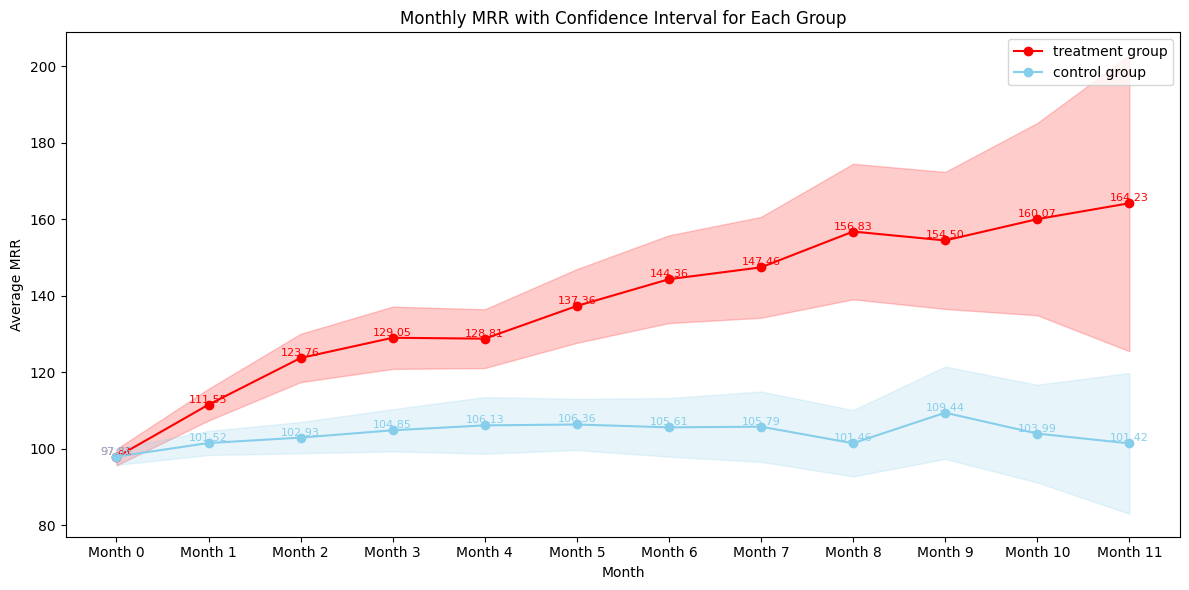

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t

# Define the function for calculating the mean and confidence interval
def calculate_means_and_ci(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = sem(data) if n > 1 else 0
    margin = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - margin, mean + margin

# Define colors for groups
group_colors = {'treatment group': 'red', 'control group': 'skyblue'}

# Prepare for plotting
plt.figure(figsize=(12, 6))

for group, color in group_colors.items():
    means = []
    lower_cis = []
    upper_cis = []
    for month in mrr_columns:
        data = final_dataset_with_monthly_mrr[(final_dataset_with_monthly_mrr['group_assignment'] == group) & final_dataset_with_monthly_mrr[month].notna()][month]
        mean, lower_ci, upper_ci = calculate_means_and_ci(data)
        means.append(mean)
        lower_cis.append(lower_ci)
        upper_cis.append(upper_ci)
    
    # Plotting mean MRR values and confidence intervals
    plt.plot(mrr_columns, means, marker="o", label=group, color=color)
    plt.fill_between(mrr_columns, lower_cis, upper_cis, color=color, alpha=0.2)
    
    # Adding data labels for mean MRR values
    for i, mean in enumerate(means):
        plt.text(mrr_columns[i], mean, f"{mean:.2f}", ha='center', va='bottom', fontsize=8, color=color)

# Plot adjustments
plt.title("Monthly MRR with Confidence Interval for Each Group")
plt.xlabel("Month")
plt.ylabel("Average MRR")
plt.legend()
plt.tight_layout()
plt.show()